# Test and use the new facebook Segment Anything Model (SAM)

Segment anything allows to segment images given various inputs: points or boxes. You can find more infomration here: https://github.com/facebookresearch/segment-anything

Is it possible to replace our actual artificial neural network by this model ? The simple answer is no. While SAM is very efficient, the input needed does not match the resolution and level of details requested by the number and location of the particles on the filters. As shown bellow, SAM will initiate the search by defining a grid of points on the image and all particles that fall outside these points would be ignored. This also has a heavy computational weight on an already heavy model. 

It is however useful to consider SAM as an helpful model to help annotating the data. It did not exist when this project started, but was quickly integrated to the different annotation tools we used.  



Note: 

- solve the custom architecture problem: [here](https://github.com/facebookresearch/detectron2/issues/4172)


In [6]:
import sys
print(sys.path)

#sys.path.append('/../../../Other')
#print(sys.path)

['/mnt/remote/workspaces/thibault.schowing/1_IMPTOX/IMPTOX/02_TransferLearning/1_keras_detectron_convertion', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/thibault.schowing/.local/lib/python3.8/site-packages', '/data/thibault.schowing/miniconda3/bin/detectron2', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/../../../Other']


In [5]:
import numpy as np



from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
from matplotlib import rcParams

import re
import cv2
from PIL import Image

import scipy.ndimage

import torch
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

import tensorflow as tf
from tensorflow import keras
import os

import cv2
import numpy as np
from matplotlib import pyplot as plt
#from scipy.misc import imsave
from scipy import ndimage
from scipy import misc
import scipy.misc
import scipy
import image_slicer
from image_slicer import join
from PIL import Image

In [12]:
# check path

from os import listdir
from os.path import isfile, join

mypath = "../../../../0_DATA/IMPTOX/01-04_COCO_annotations_and_model/facebook_SAM/"

onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

print(onlyfiles)

['sam_vit_h_4b8939.pth']


In [13]:

gpuAvailable = torch.cuda.is_available()

cfg = get_cfg()
cfg.OUTPUT_DIR = "./TrainDetectron2Model"


# Replace with the SAM
#weightsPath = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

weightsPath = "../../../../0_DATA/IMPTOX/01-04_COCO_annotations_and_model/facebook_SAM/sam_vit_h_4b8939.pth"

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
if not gpuAvailable:
    cfg.MODEL.DEVICE = 'cpu'


if not os.path.exists(weightsPath):
    print('cannot find weights at:', weightsPath, ', neural net detector cannot work.')
else:
    print('loading weights from', weightsPath)
    cfg.MODEL.WEIGHTS = weightsPath
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1   # set the testing threshold for this model
    cfg.TEST.DETECTIONS_PER_IMAGE = 6000
    predictor = DefaultPredictor(cfg)

loading weights from ../../../../0_DATA/IMPTOX/01-04_COCO_annotations_and_model/facebook_SAM/sam_vit_h_4b8939.pth


Some model parameters or buffers are not found in the checkpoint:
backbone.bottom_up.res2.0.conv1.norm.{bias, weight}
backbone.bottom_up.res2.0.conv1.weight
backbone.bottom_up.res2.0.conv2.norm.{bias, weight}
backbone.bottom_up.res2.0.conv2.weight
backbone.bottom_up.res2.0.conv3.norm.{bias, weight}
backbone.bottom_up.res2.0.conv3.weight
backbone.bottom_up.res2.0.shortcut.norm.{bias, weight}
backbone.bottom_up.res2.0.shortcut.weight
backbone.bottom_up.res2.1.conv1.norm.{bias, weight}
backbone.bottom_up.res2.1.conv1.weight
backbone.bottom_up.res2.1.conv2.norm.{bias, weight}
backbone.bottom_up.res2.1.conv2.weight
backbone.bottom_up.res2.1.conv3.norm.{bias, weight}
backbone.bottom_up.res2.1.conv3.weight
backbone.bottom_up.res2.2.conv1.norm.{bias, weight}
backbone.bottom_up.res2.2.conv1.weight
backbone.bottom_up.res2.2.conv2.norm.{bias, weight}
backbone.bottom_up.res2.2.conv2.weight
backbone.bottom_up.res2.2.conv3.norm.{bias, weight}
backbone.bottom_up.res2.2.conv3.weight
backbone.bottom_up

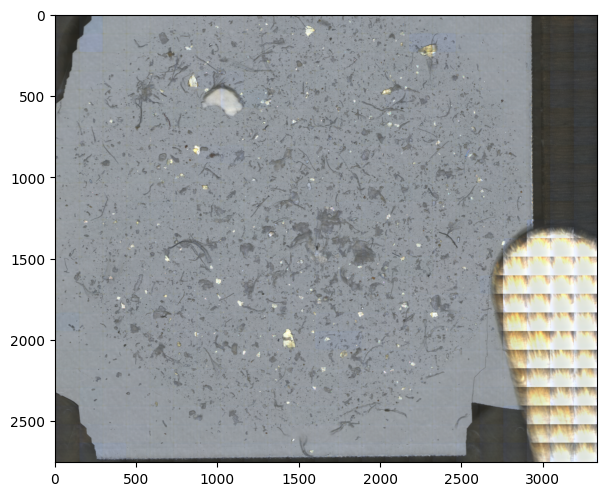

In [14]:
image_path = "../../../../0_DATA/IMPTOX/01-01_image_library/tif/Photo-_3_.tif"


image = imread(image_path)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(image)

<class 'numpy.ndarray'>
{'instances': Instances(num_instances=2, image_height=2753, image_width=3337, fields=[pred_boxes: Boxes(tensor([[   0.0000,    0.0000, 3337.0000,  816.0853],
        [   0.0000,    0.0000, 3337.0000,  158.3743]], device='cuda:0')), scores: tensor([1., 1.], device='cuda:0'), pred_classes: tensor([0, 0], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False

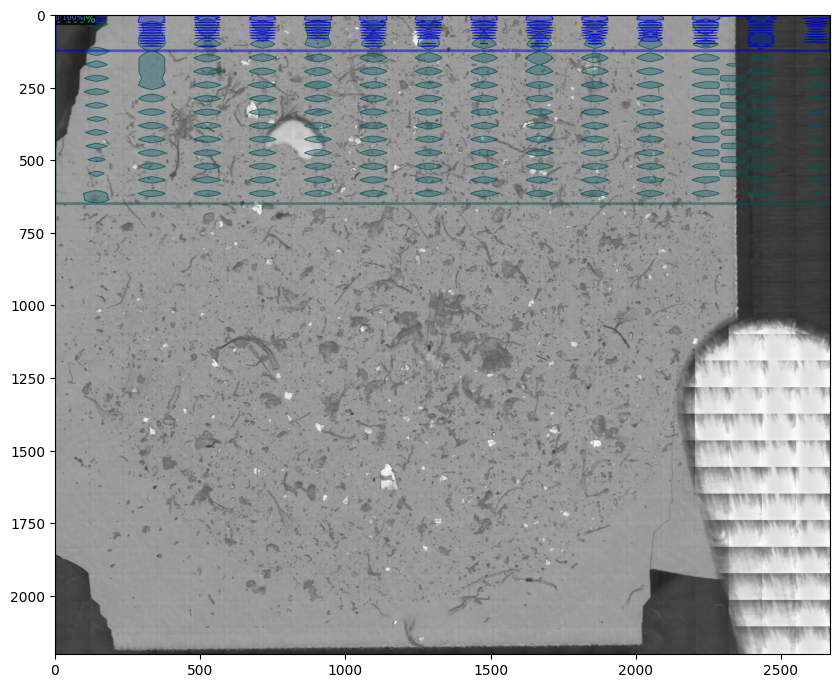

In [15]:
print(type(image))

output = predictor(image)

print(output)

v = Visualizer(image[:, :, ::-1], # flip colors from RGB to BGR
                scale=0.8, 
                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
)
v = v.draw_instance_predictions(output["instances"].to("cpu"))
    
    
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(v.get_image()[:, :, ::-1])

Cut image into pieces, annotate, reassemble

In [ ]:


img_path = '../0_data/ParticlesFilter/Images/Image2.tif'

full_image = imread(img_path)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(full_image)
plt.show()



In [ ]:
# https://stackoverflow.com/questions/43565275/split-and-join-images-in-python
num_tiles = 20
tiles = image_slicer.slice(img_path, num_tiles)
print(tiles)

print("=================================")

for i, tile in enumerate(tiles):
    
    print(f"----- Image: {tile.filename} -----")
    
    # Convert PNG (float) to uint8 pixels
    image_tile = imread(tile.filename)
    image_tile *= 255
    image_tile = image_tile.astype('uint8')

    
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(image_tile)
    plt.show()
    
    
    current_output = predictor(image_tile)
    

    v = Visualizer(image_tile[:, :, ::-1], 
                    scale=0.8, 
                    instance_mode=ColorMode.IMAGE_BW   
    )
    v = v.draw_instance_predictions(current_output["instances"].to("cpu"))

    

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(v.get_image()[:, :, ::-1])
    plt.show()

    
#image = join(tiles)

#image.save('./Image2_join.tif')

In [ ]:
image_png = imread("../0_data/ParticlesFilter/Images/Image2_01_01.png")
image_tif = imread("../0_data/ParticlesFilter/Images/Image2.tif")

print(type(image_png))
print(image_png.shape)
print(image_png[0])


print("--------------------")
print(type(image_tif))
print(image_tif.shape)
print(image_tif[0])



fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(image_png)
plt.show()


In [ ]:

output = predictor(image)

#print(output)

v = Visualizer(image[:, :, ::-1], # flip colors from RGB to BGR
                scale=0.8, 
                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
)
# Masks
for mask in output["instances"].pred_masks.to('cpu'):
    v.draw_soft_mask(mask)
v = v.get_output()
#out =  v.get_image()[:, :, ::-1]

  
    
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(v.get_image()[:, :, ::-1])
plt.show()